Model Accuracy: 1.0
F1 Score: 1.0
ROC-AUC Score: 1.0

Metrics per sensitive feature (Carrier):
          accuracy  selection_rate
carrier                          
0             1.0        0.162813
1             1.0        0.132192
2             1.0        0.096000
3             1.0        0.193258
4             1.0        0.128456
5             1.0        0.210567
6             1.0        0.274336
7             1.0        0.273567
8             1.0        0.100000
9             1.0        0.199643
10            1.0        0.000000
11            1.0        0.163204
12            1.0        0.147796
13            1.0        0.115261
14            1.0        0.179348
15            1.0        0.113636
Demographic Parity Difference for 'carrier': 0.2743362831858407


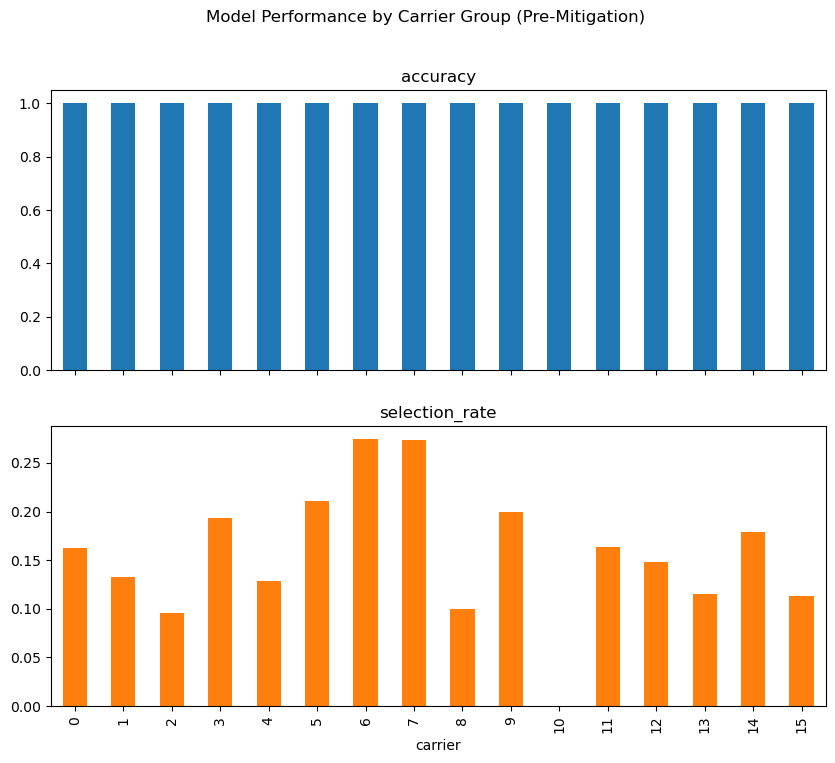

The grid has 15 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 10 grid points. It is recommended to use at least 32768 grid points. Please consider increasing grid_size.



Post-Mitigation Accuracy: 0.7298905006397155
Post-Mitigation F1 Score: 0.19019627378698817
Post-Mitigation ROC-AUC Score: 0.5139044184049641
Post-Mitigation Demographic Parity Difference: 1.0


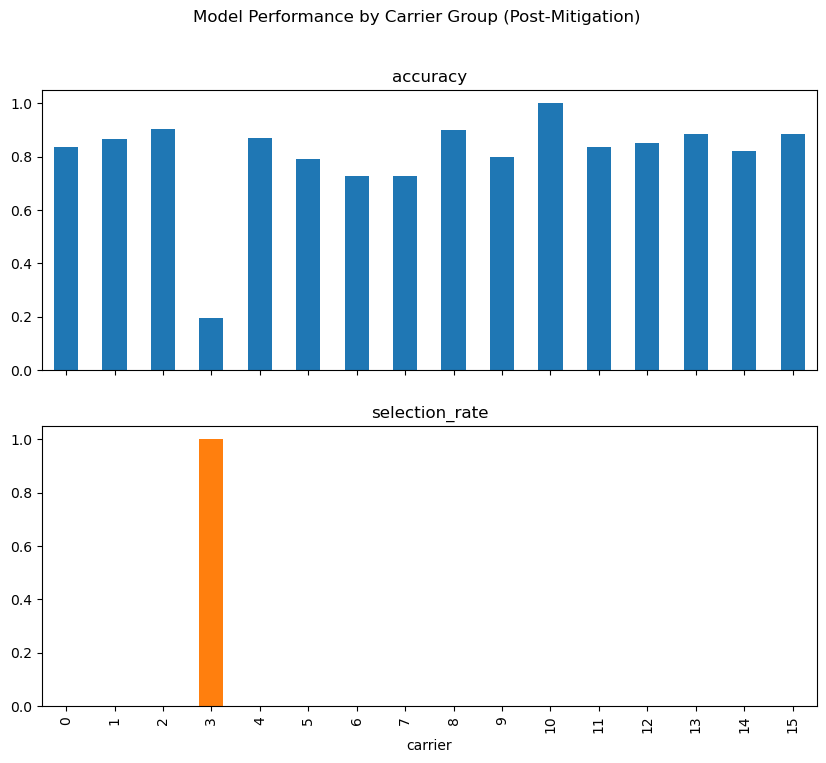

2024-11-12 10:44:18.905592: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 10:44:18.906812: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 10:44:18.931541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 10:44:19.651957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. M


Generated Recommendations:
 
The bias analysis on airline delays reveals that certain carriers face a higher risk of delays, potentially affecting customer satisfaction. To address these disparities, airline management should:
- Increase monitoring and resource allocation to carriers with frequent delays.
- Implement targeted efficiency strategies based on delay patterns by carrier.
- Foster communication with passengers to set clear expectations.

What other strategies could further minimize delay-based disparities across carriers?

How do carrier services affect passengers?

A frequent passenger service often provides better customer service. People in particular may not appreciate the cost of their frequent-day service, but sometimes the service may be a more economical way to spend a couple of hours with them.

If you use a frequent-day service, you should consider using a different plan. For example, you might decide to buy a service based on the price, time, and quality (for ins

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('./DataSets/KaggleData/flights_gold.csv')

# Handle missing values in important columns
df['arr_delay'].fillna(df['arr_delay'].mean(), inplace=True)
df['dep_delay'].fillna(df['dep_delay'].mean(), inplace=True)

# Combine year, month, and day to create flight_date and extract time-based features
df['flight_date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['day_of_week'] = df['flight_date'].dt.dayofweek
df['hour_of_day'] = df['dep_time'].astype(str).str.replace(r'\.', '', regex=True).str.slice(0, 2).astype(int)
df['flight_duration'].fillna(df['flight_duration'].mean(), inplace=True)
df['distance'].fillna(df['distance'].mean(), inplace=True)

# Encode categorical features and create a binary target for delay
le_carrier = LabelEncoder()
df['carrier'] = le_carrier.fit_transform(df['carrier'])
features = ['day_of_week', 'hour_of_day', 'dep_delay', 'arr_delay', 'carrier', 'distance', 'flight_duration']
X = df[features]
df['target_binary'] = (df['arr_delay'] > 15).astype(int)
df.dropna(subset=['target_binary'], inplace=True)
y = df['target_binary']

# Define sensitive attribute for bias analysis (e.g., 'carrier' as a potential source of bias)
sensitive_feature = df['carrier']

# Split the data
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(X, y, sensitive_feature, test_size=0.2, random_state=42)

# Initialize and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate baseline model performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}\nF1 Score: {f1}\nROC-AUC Score: {roc_auc}")

# Quantitative bias analysis using Fairlearn's MetricFrame
metric_frame = MetricFrame(
    metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test
)
print("\nMetrics per sensitive feature (Carrier):\n", metric_frame.by_group)

# Calculate and display demographic parity difference
dem_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Demographic Parity Difference for 'carrier': {dem_parity_diff}")

# Visualize potential bias
metric_frame.by_group.plot.bar(subplots=True, layout=(2, 1), figsize=(10, 8), legend=False)
plt.suptitle("Model Performance by Carrier Group (Pre-Mitigation)")
plt.show()

# Bias mitigation using Fairlearn's GridSearch with Demographic Parity
mitigator = GridSearch(estimator=RandomForestClassifier(random_state=42), constraints=DemographicParity())
mitigator.fit(X_train, y_train, sensitive_features=sensitive_train)
y_pred_mitigated = mitigator.predict(X_test)

# Post-mitigation evaluation
post_mitigation_accuracy = accuracy_score(y_test, y_pred_mitigated)
post_mitigation_f1 = f1_score(y_test, y_pred_mitigated)
post_mitigation_roc_auc = roc_auc_score(y_test, y_pred_mitigated)
post_dem_parity_diff = demographic_parity_difference(y_test, y_pred_mitigated, sensitive_features=sensitive_test)

print(f"\nPost-Mitigation Accuracy: {post_mitigation_accuracy}")
print(f"Post-Mitigation F1 Score: {post_mitigation_f1}")
print(f"Post-Mitigation ROC-AUC Score: {post_mitigation_roc_auc}")
print(f"Post-Mitigation Demographic Parity Difference: {post_dem_parity_diff}")

# Visualize post-mitigation performance
post_metric_frame = MetricFrame(
    metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_test
)
post_metric_frame.by_group.plot.bar(subplots=True, layout=(2, 1), figsize=(10, 8), legend=False)
plt.suptitle("Model Performance by Carrier Group (Post-Mitigation)")
plt.show()

# Qualitative Analysis: Generating Actionable Insights
from transformers import pipeline

# Initialize text generation model for recommendations
generator = pipeline('text-generation', model='gpt2')

prompt = """
The bias analysis on airline delays reveals that certain carriers face a higher risk of delays, potentially affecting customer satisfaction. To address these disparities, airline management should:
- Increase monitoring and resource allocation to carriers with frequent delays.
- Implement targeted efficiency strategies based on delay patterns by carrier.
- Foster communication with passengers to set clear expectations.

What other strategies could further minimize delay-based disparities across carriers?
"""

# Generate recommendations text
generated_text = generator(prompt, max_length=200, num_return_sequences=1)
print("\nGenerated Recommendations:\n", generated_text[0]['generated_text'])
